# Model 1:

## Imports

In [22]:
import datetime
import time
import requests
import pandas as pd
from spellchecker import SpellChecker
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error

## Pulling Functions

In [3]:

def get_subreddit_df(subreddit, max_size=1000):
    '''
    give function a subreddit string returns df of all 
    '''
    # base url
    base_url = 'https://api.pushshift.io/reddit/search/'
    # return df
    df = pd.DataFrame()
    # initial params
    params = {
        'subreddit' : subreddit, # /r page
        'size' : 500, # get max size
        'over_18': 'false', # remove nsfw posts
        'before': 1650603966, # start date
        'after': 1648875966, # end date
        'is_video': False
    }
    # loop to get df of elements
    while df.shape[0] < max_size:
        res = requests.get(base_url + 'submission/', params = params)
        # check if request cant pull
        if res.status_code != 200:
            print(f'Issue Pulling Data :: status code :: {res.status_code}')
            return df
        # make current timefram df
        current_df = pd.DataFrame(res.json()['data'])[['subreddit', 'selftext', 'title']]
        current_df['title'] = current_df['title']
        # add current df to historical df
        df = pd.concat([df, current_df], axis=0)
        # decrese start time - 20 days
        before_dt_time = datetime.datetime.fromtimestamp(params['before'])
        new_dt_b = before_dt_time - datetime.timedelta(days=20)
        params['before'] = int(new_dt_b.strftime('%s'))
        # decrease end time - 20 days
        after_dt_time = datetime.datetime.fromtimestamp(params['after'])
        new_dt_a = after_dt_time - datetime.timedelta(days=20)
        params['after'] = int(new_dt_a.strftime('%s'))
        # added sleep to not cause 429 error :: to mant pulls
        time.sleep(3)
    return df

## Import Subreddit DF's
- remove repeated entries
- remove deleted comments

In [4]:
# pull the two sub reddits
explain_like_im_five_df = get_subreddit_df('explainlikeimfive', max_size=5000)
explain_like_im_five_df['subreddit'] = 1


In [5]:
# explain_like_im_five_df.shape, shower_thoughts.shape
shower_thoughts = get_subreddit_df('NoStupidQuestions', max_size=5000)
shower_thoughts['subreddit'] = 0

## Spellchecker Function

In [6]:
def spellcheck(df, col=''):
    copy_df = df.copy()
    spell = SpellChecker()
    # correct the spelling of sentences
    copy_df[f'corrected_{col}'] = [spell.split_words(sentence.translate(str.maketrans('', '', string.punctuation)).lower())[1::] for sentence in copy_df[col]]
    # remove the numeric
    # remove all string that contain 'elif'
    return copy_df


In [8]:

subredt_joined_df = pd.concat([spellcheck(explain_like_im_five_df, col='title'), spellcheck(shower_thoughts, col='title')], axis=0)

In [10]:
subredt_joined_df['subreddit'].value_counts(normalize=True)

1    0.501556
0    0.498444
Name: subreddit, dtype: float64

## Count Vetorize

In [11]:
X = subredt_joined_df['title'] # identify X
y = subredt_joined_df['subreddit'] # identify y

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) # train test split

In [13]:
cv = CountVectorizer(stop_words='english') # count Vectorizer

cv.fit(X_train)

X_train_cv = cv.transform(X_train) # X_train tranform CV
X_test_cv = cv.transform(X_test) # X_test transform CV

In [14]:
text_df = pd.DataFrame(data=X_train_cv.A, columns=cv.get_feature_names_out()) # makeing Countvectorizer df

## Making Model

In [16]:
lr = LogisticRegression(max_iter=10_000)
lr.fit(X_train_cv, y_train)

LogisticRegression(max_iter=10000)

In [17]:
lr.score(X_train_cv, y_train), lr.score(X_test_cv, y_test)

(0.9993614303959132, 0.999043062200957)

In [23]:
preds = lr.predict(X_test_cv)

## EDA Coef_/Model

In [18]:
coef_df = pd.DataFrame(lr.coef_[0], index=cv.get_feature_names_out(), columns=['coef_val'])

In [19]:
coef_df.sort_values(by='coef_val').head(50)

,coef_val
people,-0.179382
just,-0.176218
reddit,-0.161714
way,-0.132070
mean,-0.129110
really,-0.105110
hate,-0.103803
stop,-0.100270
eat,-0.099955
lot,-0.097785


In [20]:
coef_df.sort_values(by='coef_val').tail(50)

,coef_val
moon,0.037887
loss,0.038537
works,0.039793
brain,0.040183
instead,0.040323
currency,0.040729
rich,0.041055
understand,0.041216
culture,0.041475
car,0.042076


In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

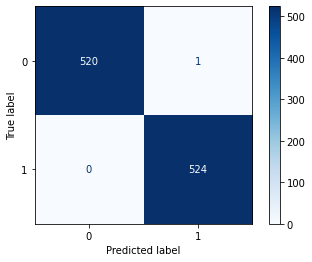

In [46]:
ConfusionMatrixDisplay.from_estimator(lr, X_test_cv, y_test, cmap='Blues')

In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, preds, squared=False)

0.0309344112444873